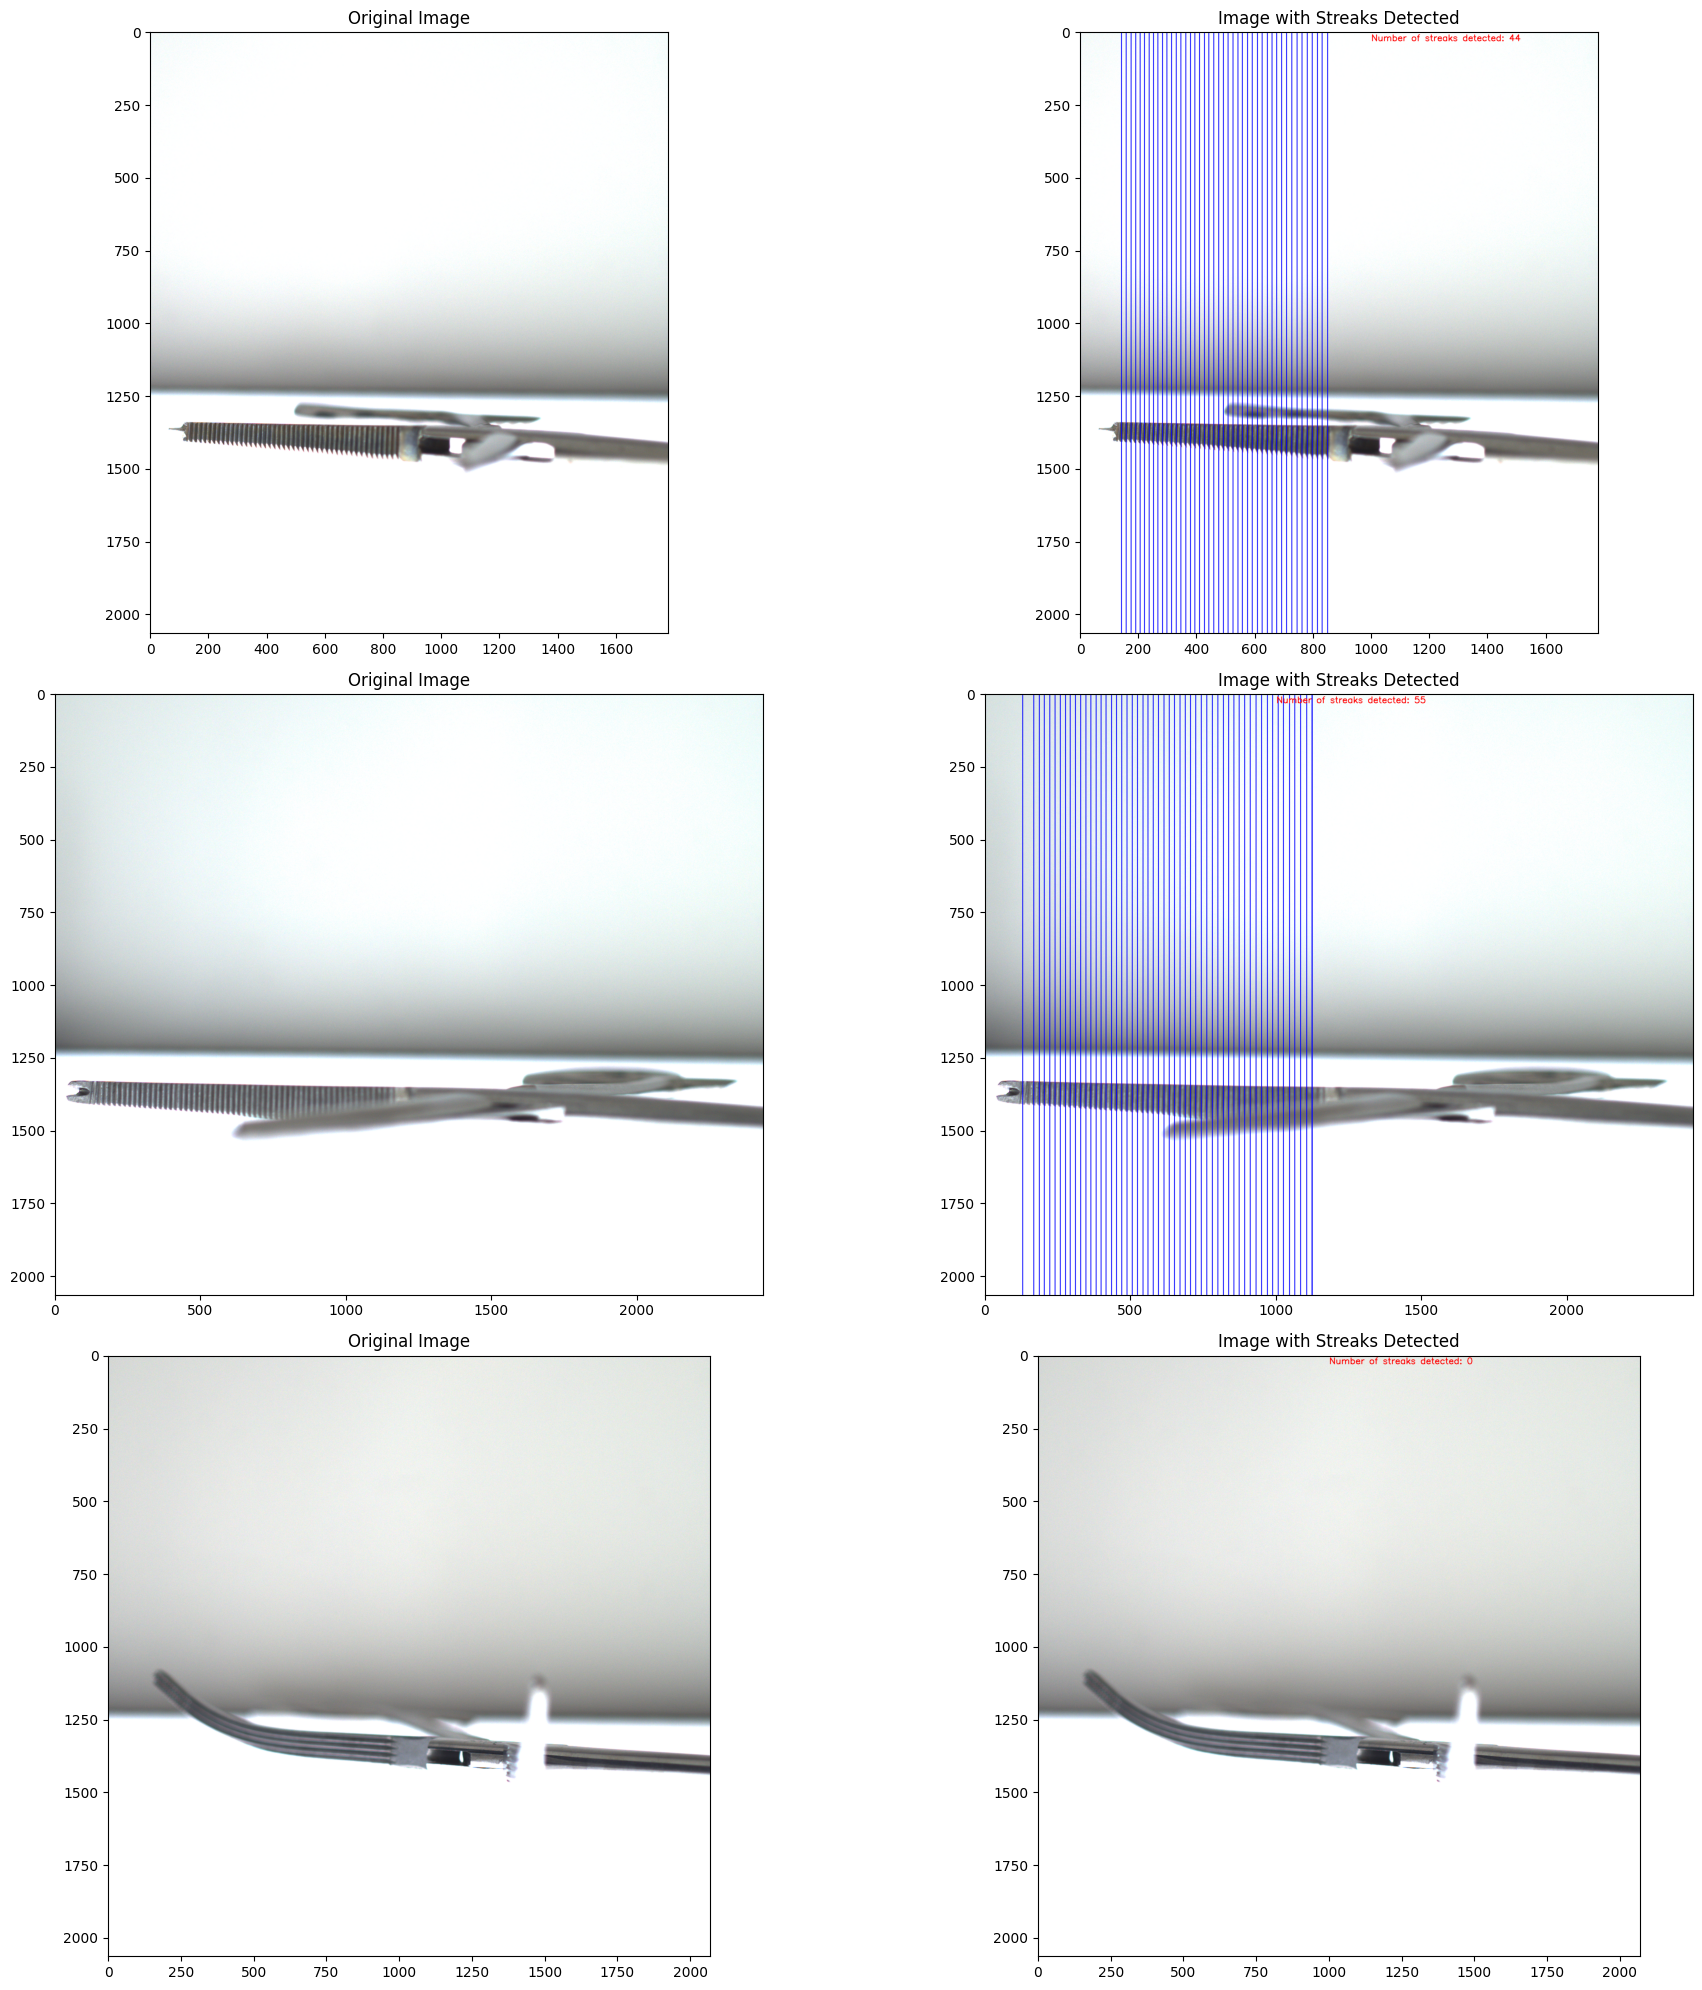

In [4]:
import os
import cv2
import json
import matplotlib.pyplot as plt

def segment_image(article_image, empty_room_image, crop_value, threshold):
    article_image = cv2.medianBlur(article_image, 3)

    article_height, article_width = article_image.shape[:2]

    resized_empty_room_image = cv2.resize(empty_room_image, (article_width + crop_value, article_height), interpolation=cv2.INTER_AREA)

    padded_article_image = cv2.copyMakeBorder(article_image, 0, 0, crop_value, 0, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    segmentation = cv2.absdiff(padded_article_image, resized_empty_room_image)

    segmentation_gray = cv2.cvtColor(segmentation, cv2.COLOR_BGR2GRAY)

    _, segmentation_thresh = cv2.threshold(segmentation_gray, threshold, 255, cv2.THRESH_BINARY)

    segmentation_cropped = segmentation_thresh[:, crop_value:]

    return segmentation_cropped

def detect_streaks(segmented_image, original_image, min_height, min_width, max_aspect_ratio):
    contours, _ = cv2.findContours(segmented_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    streaks = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        aspect_ratio = w / float(h)

        if h > min_height and w > min_width and aspect_ratio < max_aspect_ratio:
            streaks.append(cnt)

    for cnt in streaks:
        x, y, w, h = cv2.boundingRect(cnt)
        start_point = (x + w // 2, 0)
        end_point = (x + w // 2, original_image.shape[0])
        cv2.line(original_image, start_point, end_point, (255, 0, 0), 2)

    return len(streaks), original_image

def process_image(article_image_path, empty_room_image_path, crop_json_path, threshold=160):
    empty_room_image = cv2.imread(empty_room_image_path)

    with open(crop_json_path, 'r') as json_file:
        data = json.load(json_file)
    crop_value = data["left"]

    article_image = cv2.imread(article_image_path)

    segmentation_result = segment_image(article_image, empty_room_image, crop_value, threshold)
    number_of_streaks, image_with_streaks = detect_streaks(segmentation_result, article_image, 5, 2, 0.5)

    return number_of_streaks, image_with_streaks

image_dir = r"C:\Users\Yassine\Desktop\Streak_Detection\Dataset"
image_files = ['article1.png', 'article2.png', 'article3.png']

# Create a subplot for displaying images side by side
fig, axs = plt.subplots(len(image_files), 2, figsize=(20, 20))

for i, image_file in enumerate(image_files):
    article_image_path = os.path.join(image_dir, image_file)
    empty_room_image_path = os.path.join(image_dir, 'empty_room.png')
    crop_json_path = os.path.join(image_dir, f'crop_{image_file[:-4]}.json')

    number_of_streaks, image_with_streaks = process_image(article_image_path, empty_room_image_path, crop_json_path)

    # Display the original image
    axs[i, 0].imshow(cv2.cvtColor(cv2.imread(article_image_path), cv2.COLOR_BGR2RGB))
    axs[i, 0].set_title('Original Image')

    # Display the image with streaks detected
    cv2.putText(image_with_streaks, f"Number of streaks detected: {number_of_streaks}", (1000, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    axs[i, 1].imshow(cv2.cvtColor(image_with_streaks, cv2.COLOR_BGR2RGB))
    axs[i, 1].set_title('Image with Streaks Detected')

plt.tight_layout()
plt.show()
